useful resource: https://towardsdatascience.com/a-complete-exploratory-data-analysis-and-visualization-for-text-data-29fb1b96fb6a

In [1]:
#code needed to use colab notebook
#if you're using juptyer notebook then skip this line
from google.colab import drive
drive.mount('/content/gdrive')

ModuleNotFoundError: No module named 'google.colab'

## these modules need to be installed before starting

In [51]:
pip install chart_studio 

Note: you may need to restart the kernel to use updated packages.


In [52]:
pip install scattertext

Note: you may need to restart the kernel to use updated packages.


In [53]:
!python -m spacy download en_core_web_sm

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')


In [54]:
import pandas as pd
import numpy as np
from textblob import TextBlob
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import warnings 
warnings.filterwarnings('ignore')
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10.0, 6.0)
import plotly.graph_objs as go
import chart_studio.plotly as py
import cufflinks
pd.options.display.max_columns = 30
from IPython.core.interactiveshell import InteractiveShell
import plotly.figure_factory as ff
InteractiveShell.ast_node_interactivity = 'all'
from plotly.offline import iplot
cufflinks.go_offline()
cufflinks.set_config_file(world_readable=True, theme='pearl')
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook
output_notebook()
from collections import Counter
import scattertext as st
import spacy
from pprint import pprint
import en_core_web_sm
#nlp = spacy.load('en_core_web_md')
nlp = en_core_web_sm.load()

Loading BokehJS ...

In [55]:
%cd ~/Documents/GitHub/esade_fake_news/1_Climate_Change/youtube_query/data/nlp
!ls

/Users/Pierre/Documents/GitHub/esade_fake_news/1_Climate_Change/youtube_query/data/nlp
00000000-000000_climate_change_bias.csv
00000000-000000_climate_change_nlp.csv
00000000-000000_climate_change_nlp_subs.csv
00000000-000000_climate_change_nlp_subs_clean.csv
00000000-000000_climate_change_nlp_subs_clean_expanded.csv
20200507-033205_climate_change_bias.csv
20200507-033205_climate_change_nlp.csv
20200507-033205_climate_change_nlp_subs.csv
20200507-033205_climate_change_nlp_subs2.csv
20200507-033205_climate_change_nlp_subs_clean.csv
20200507-033205_climate_change_nlp_subs_clean_expanded.csv
notebooks


In [56]:
# load train_cleaned.csv
filename = "00000000-000000_climate_change_nlp_subs_clean.csv"
df = pd.read_csv(filename, index_col=0)

df.head()

,Bias_num,text
4,0.0,[] yeah Irish aqua five bucks North North Kore...
5,0.0,you can't say it but you know it's true good e...
6,0.0,[] [] there is a certaty to life Roberts Coun...
7,0.0,honestly what they say doesn't bother me I und...
12,0.0,do I believe UFOs or extraterrestrial visitor...


## Analysis

In [57]:
#calculate number of characters
df['review_len'] = df['text'].astype(str).apply(len)

#calculate number of words
df['word_count'] = df['text'].apply(lambda x: len(str(x).split()))
df.head()

,Bias_num,text,review_len,word_count
4,0.0,[] yeah Irish aqua five bucks North North Kore...,21635,4062
5,0.0,you can't say it but you know it's true good e...,15173,2858
6,0.0,[] [] there is a certaty to life Roberts Coun...,28605,5404
7,0.0,honestly what they say doesn't bother me I und...,2585,490
12,0.0,do I believe UFOs or extraterrestrial visitor...,16947,3141


(array([501., 279., 121.,  44.,  15.,   9.,   3.,   5.,   1.,   1.]),
 array([  1181. ,  15415.4,  29649.8,  43884.2,  58118.6,  72353. ,
         86587.4, 100821.8, 115056.2, 129290.6, 143525. ]),
 <a list of 10 Patch objects>)

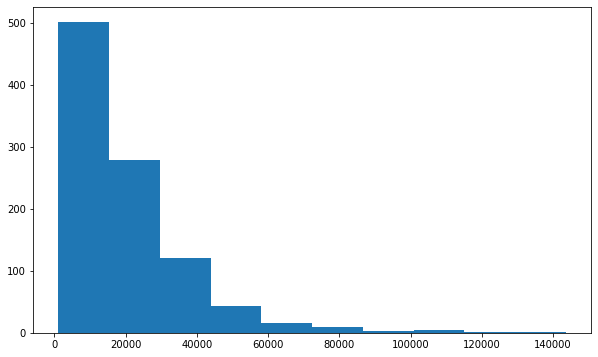

In [58]:
plt.hist(df['review_len'])

(array([531., 251., 115.,  51.,  14.,   7.,   3.,   5.,   1.,   1.]),
 array([  204.,  2734.,  5264.,  7794., 10324., 12854., 15384., 17914.,
        20444., 22974., 25504.]),
 <a list of 10 Patch objects>)

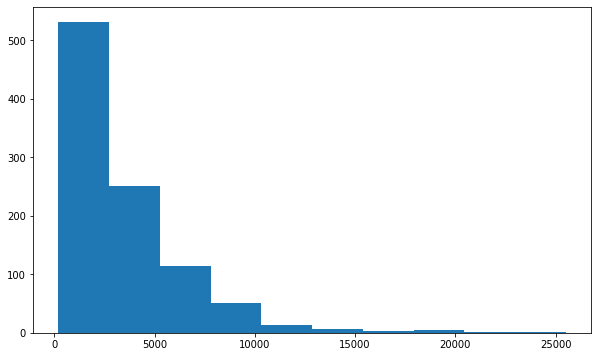

In [59]:
plt.hist(df['word_count'])

In [60]:
x1 = df.loc[df['Bias_num'] == 1, 'word_count']
x0 = df.loc[df['Bias_num'] == 0, 'word_count']

trace1 = go.Histogram(
    x=x0, name='Right',
    opacity=0.75
)
trace2 = go.Histogram(
    x=x1, name = 'Left',
    opacity=0.75
)

data = [trace1, trace2]
layout = go.Layout(barmode='overlay', title='Distribution of word count based on bias')
fig = go.Figure(data=data, layout=layout)
fig.show()

In [61]:
x1 = df.loc[df['Bias_num'] == 1, 'review_len']
x0 = df.loc[df['Bias_num'] == 0, 'review_len']

trace1 = go.Histogram(
    x=x0, name='Right',
    opacity=0.75
)
trace2 = go.Histogram(
    x=x1, name = 'Left',
    opacity=0.75
)

data = [trace1, trace2]
layout = go.Layout(barmode='overlay', title='Distribution of review_len based on bias')
fig = go.Figure(data=data, layout=layout)
fig.show()

## The distribution of top unigrams before removing stop words

In [62]:
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_words(df['text'], 20)
df1 = pd.DataFrame(common_words, columns = ['text' , 'count'])
df1
df1.groupby('text').sum()['count'].sort_values(ascending=False).iplot(
    kind='bar', yTitle='Count', linecolor='black', title='Top 20 words in review before removing stop words')

,text,count
0,the,179645
1,to,109836
2,that,82450
3,you,76276
4,it,63081
5,is,52741
6,we,49099
7,this,34641
8,was,29518
9,they,28094


## The distribution of top unigrams after removing stop words

In [63]:
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer(stop_words = 'english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_words(df['text'], 20)
df2 = pd.DataFrame(common_words, columns = ['text' , 'count'])
df2
df2.groupby('text').sum()['count'].sort_values(ascending=False).iplot(
    kind='bar', yTitle='Count', linecolor='black', title='Top 20 words in review after removing stop words')

,text,count
0,people,16849
1,know,13130
2,like,12877
3,just,12543
4,thk,10477
5,don,10258
6,gog,9160
7,right,9126
8,ve,8667
9,time,7363


## The distribution of top bigrams before removing stop words

In [64]:
def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_bigram(df['text'], 20)
df3 = pd.DataFrame(common_words, columns = ['text' , 'count'])
df3
df3.groupby('text').sum()['count'].sort_values(ascending=False).iplot(
    kind='bar', yTitle='Count', linecolor='black', title='Top 20 bigrams in review before removing stop words')


,text,count
0,to the,8818
1,to be,7151
2,you re,6931
3,this is,6819
4,if you,6620
5,gog to,6594
6,you know,6086
7,we re,6013
8,on the,5928
9,that the,5285


## The distribution of top bigrams after removing stop words

In [65]:
def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_bigram(df['text'], 20)
df4 = pd.DataFrame(common_words, columns = ['text' , 'count'])
df4
df4.groupby('text').sum()['count'].sort_values(ascending=False).iplot(
    kind='bar', yTitle='Count', linecolor='black', title='Top 20 bigrams in review after removing stop words')

,text,count
0,ve got,1767
1,don know,1667
2,united states,1548
3,years ago,1124
4,little bit,999
5,don thk,878
6,don want,783
7,close quote,701
8,donald trump,620
9,climate change,526


## The distribution of Top trigrams before removing stop words

In [66]:
def get_top_n_trigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(3, 3)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_trigram(df['text'], 20)
df5 = pd.DataFrame(common_words, columns = ['text' , 'count'])
df5
df5.groupby('text').sum()['count'].sort_values(ascending=False).iplot(
    kind='bar', yTitle='Count', linecolor='black', title='Top 20 trigrams in review before removing stop words')

,text,count
0,re gog to,1535
1,the united states,1460
2,gog to be,1150
3,you have to,1002
4,if you re,990
5,this is the,981
6,you want to,927
7,we have to,891
8,we re gog,852
9,you ve got,763


## The distribution of Top trigrams after removing stop words

In [67]:
def get_top_n_trigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(3, 3), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_trigram(df['text'], 20)
df6 = pd.DataFrame(common_words, columns = ['text' , 'count'])
df6
df6.groupby('text').sum()['count'].sort_values(ascending=False).iplot(
    kind='bar', yTitle='Count', linecolor='black', title='Top 20 trigrams in review after removing stop words')

,text,count
0,uncommon knowledge peter,168
1,knowledge peter robson,164
2,welcome uncommon knowledge,148
3,million years ago,95
4,president united states,90
5,want make sure,82
6,know don know,76
7,victor davis hanson,76
8,couple years ago,75
9,uncommon knowledge hoover,72


## Finding characteristic terms and their associations

In [68]:
#convert Bias_num to string
df_corpus = df.copy()
df_corpus['Bias_num'] = df_corpus['Bias_num'].apply(str)
df_corpus.dtypes

Bias_num      object
text          object
review_len     int64
word_count     int64
dtype: object

In [69]:
#Following are the terms that differentiate the review text from a general English corpus.
corpus = st.CorpusFromPandas(df_corpus, category_col='Bias_num', text_col='text', nlp=nlp).build()
print(list(corpus.get_scaled_f_scores_vs_background().index[:10]))

['thk', 'gog', 'thgs', 'somethg', 'thg', 'aga', 'beg', 'sayg', 'gon', 'gettg']


In [71]:
#Following are the terms in review text that are most associated with right wing channels:
term_freq_df = corpus.get_term_freq_df()
term_freq_df['Right score'] = corpus.get_scaled_f_scores("1.0")
pprint(list(term_freq_df.sort_values(by='Right score', ascending=False).index[:20]))

['close quote',
 'stal',
 'blacks',
 'reagan',
 'soviet',
 'argument',
 'all right',
 'the soviet',
 'peter',
 'union',
 'quote',
 'uncommon knowledge',
 'uncommon',
 'the book',
 'soviet union',
 'andrew',
 'black',
 'century',
 'knowledge',
 'nation']


In [72]:
#Following are the terms in review text that are most associated with left wing channels:
term_freq_df = corpus.get_term_freq_df()
term_freq_df['Left score'] = corpus.get_scaled_f_scores("0.0")
pprint(list(term_freq_df.sort_values(by='Left score', ascending=False).index[:20]))

["you\\'ve",
 "i\\'ve",
 "doesn\\'t",
 "you\\'re",
 "we\\'ve",
 "we\\'re",
 'he\\',
 "i\\'m",
 "it\\ 's",
 'it\\',
 "they\\'re",
 "can\\'t",
 "he\\ 's",
 'and i',
 'what\\',
 "what\\ 's",
 "don\\'t",
 '\\',
 "didn\\'t",
 "\\ 's"]
